## Application of batch-mode regression to cross-validation

botorch provides a helper function `gen_loo_cv_folds` to easily perform leave-one-out (LOO) cross-validation (CV) by taking advantage of batch-mode regression and evaluation in GPyTorch. This tutorial illustrates the process on a noisy sinusoidal function, similar to the example from the batch-mode GP regression [tutorial](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb) from GPyTorch:

$$y = \sin(2\pi x) + \epsilon, ~\epsilon \sim \mathcal N(0, 0.2).$$

Note: this tutorial aims to introduce batch-mode regression and evaluation in GPyTorch with CV as an example application. For alternative, more user-friendly functions to perform CV in Ax, see [ax.modelbridge.cross_validation](https://github.com/facebook/Ax/blob/main/ax/modelbridge/cross_validation.py). However, for larger CV tasks, it may be useful to exploit GPyTorch batch-mode, as shown in this tutorial.

In [1]:
import torch
import math

device = torch.device("cpu")
dtype = torch.float64
torch.manual_seed(3);

### Initialize the CV dataset

For our training data, we take 20 regularly spaced points on the interval $[0, 1]$ and generate noisy evaluations with an observed noise variance of 0.2. Remember that botorch requires an explicit output dimension.

In [2]:
sigma = math.sqrt(0.2)
train_X = torch.linspace(0, 1, 20, dtype=dtype, device=device).view(-1, 1)
train_Y_noiseless = torch.sin(train_X * (2 * math.pi))
train_Y = train_Y_noiseless + sigma * torch.randn_like(train_Y_noiseless)
train_Yvar = torch.full_like(train_Y, 0.2)

The botorch function `gen_loo_cv_folds` takes our observed data `train_X`, `train_Y`, `train_Yvar` as input and returns the LOO CV folds in a `CVFolds` object.

In [3]:
from botorch.cross_validation import gen_loo_cv_folds

cv_folds = gen_loo_cv_folds(train_X=train_X, train_Y=train_Y, train_Yvar=train_Yvar)

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


The `cv_folds` object contains the data, stored as tensors of appropriate batch shape, necessary to perform 20 CVs of 19 training points and 1 test point. For example, we can check that the shapes of the training inputs and training targets are `b x n x d = 20 x 19 x 1` and `b x n x o = 20 x 19 x 1` respectively, where `o` is the number of outputs.

In [4]:
cv_folds.train_X.shape, cv_folds.train_Y.shape

(torch.Size([20, 19, 1]), torch.Size([20, 19, 1]))

In [5]:
cv_folds.test_X.shape, cv_folds.test_Y.shape

(torch.Size([20, 1, 1]), torch.Size([20, 1, 1]))

Note that in a situation where the dataset is large, one may not want to perform LOO; in that case, a similar process can be used to perform $k$-fold CV.

### Perform LOOCV

We can use the `batch_cross_validation` function to perform LOOCV using batching (meaning that the `b = 20` sets of training data can be fit as `b = 20` separate GP models with separate hyperparameters in parallel through GPyTorch) and return a CVResult tuple with the batched `GPyTorchPosterior` object over the LOOCV test points and the observed targets. The `batch_cross_validation` requires a model class (`model_cls`) and a marginal log likelihood class (`mll_cls`). Since we have an observed and constant noise level, we will use the FixedNoiseGP as the `model_cls` and an ExactMarginalLogLikelihood as the `mll_cls`.

In [6]:
from botorch.cross_validation import batch_cross_validation
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

input_transform = Normalize(d=train_X.shape[-1])
outcome_transform = Standardize(
    m=train_Y.shape[-1],
    batch_shape=cv_folds.train_Y.shape[:-2],
)

# instantiate and fit model
cv_results = batch_cross_validation(
    model_cls=SingleTaskGP,
    mll_cls=ExactMarginalLogLikelihood,
    cv_folds=cv_folds,
    model_init_kwargs={
        "input_transform": input_transform,
        "outcome_transform": outcome_transform,
    },
)

/Users/santorella/botorch/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


#### Compute the cross-validation error and generate plots
To compute the cross-validation error, we first evaluate the test points by computing the posterior in batch mode. Next, we compute the squared errors for each test point from the prediction and take an average across all cross-validation folds.

Cross-validation error:  0.16


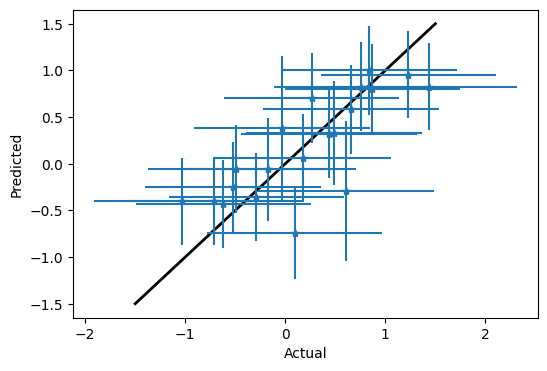

In [7]:
from matplotlib import pyplot as plt

%matplotlib inline

posterior = cv_results.posterior
mean = posterior.mean
cv_error = ((cv_folds.test_Y.squeeze() - mean.squeeze()) ** 2).mean()
print(f"Cross-validation error: {cv_error : 4.2}")

# get lower and upper confidence bounds
lower, upper = posterior.mvn.confidence_region()

# scatterplot of predicted versus test
_, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.plot([-1.5, 1.5], [-1.5, 1.5], "k", label="true objective", linewidth=2)

axes.set_xlabel("Actual")
axes.set_ylabel("Predicted")

axes.errorbar(
    x=cv_folds.test_Y.numpy().flatten(),
    y=mean.numpy().flatten(),
    xerr=1.96 * sigma,
    yerr=((upper - lower) / 2).numpy().flatten(),
    fmt="*",
);

Finally, we can visualize the fitted models. To do this, we again take advantage of batch-mode evaluation to obtain predictions, including lower and upper confidence regions, from each of the 20 models.

In [8]:
model = cv_results.model
with torch.no_grad():
    # evaluate the models at a series of points for plotting
    plot_x = (
        torch.linspace(0, 1, 101).view(1, -1, 1).repeat(cv_folds.train_X.shape[0], 1, 1)
    )
    posterior = model.posterior(plot_x)
    mean = posterior.mean

    # get lower and upper confidence bounds
    lower, upper = posterior.mvn.confidence_region()
    plot_x.squeeze_()

The code snippet below plots the result for the 12th CV fold (by setting `num = 12`), but note that we have computed the results for all folds above (other plots can be obtained by iterating `num` from 1 to 20).

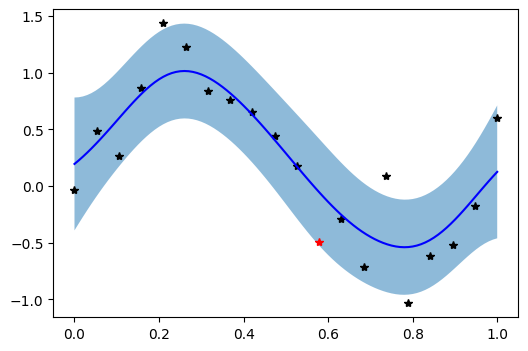

In [9]:
_, axes = plt.subplots(1, 1, figsize=(6, 4))

# plot the 12th CV fold
num = 12

# plot the training data in black
axes.plot(
    cv_folds.train_X[num - 1].detach().numpy(),
    cv_folds.train_Y[num - 1].detach().numpy(),
    "k*",
)

# plot the test data in red
axes.plot(
    cv_folds.test_X[num - 1].detach().numpy(),
    cv_folds.test_Y[num - 1].detach().numpy(),
    "r*",
)

# plot posterior means as blue line
axes.plot(plot_x[num - 1].numpy(), mean[num - 1].numpy(), "b")

# shade between the lower and upper confidence bounds
axes.fill_between(
    plot_x[num - 1].numpy(), lower[num - 1].numpy(), upper[num - 1].numpy(), alpha=0.5
);